In [2]:
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 827.9 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import nltk

import pandas as pd

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import string
import spacy
import numpy as np
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import itertools
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [19]:
from scipy import spatial


In [2]:
import en_core_web_lg

nlp = en_core_web_lg.load()

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:


df = pd.read_csv("data.csv") 

In [ ]:

df.head()


In [9]:
def remove_non_english_words(word):
  review = re.sub('[^a-zA-Z0-9]', ' ', word)
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  return review

In [10]:
def embed(tokens, nlp):
      
      lexemes = (nlp.vocab[token] for token in tokens)

      vectors = np.asarray([
            lexeme.vector
            for lexeme in lexemes
            if lexeme.has_vector
            and not lexeme.is_stop
            and len(lexeme.text) > 1
      ])
      if len(vectors) > 0:
            centroid = vectors.mean(axis=0)
      else:
            width = nlp.meta['vectors']['width']  # typically 300
            centroid = np.zeros(width)

      return centroid


In [11]:

def predict(doc, nlp, neigh):
      doc = remove_non_english_words(doc)
      tokens = doc.split(' ')
      centroid = embed(tokens, nlp)
      closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
      return closest_label


In [12]:
news_topics = {0: "general news", 1: "sport", 2: "tech", 3: "world", 4: "finance", 5: "politics", 6: "business", 7: "economics", 
               8: "entertainment", 9: "beauty", 10: "gaming", 11:"science", 12:"travel", 13:"energy", 14:"music", 15:"food"}

r_news_topics = {y: x for x, y in news_topics.items()}


In [50]:

label_names = list(news_topics.values())

label_names.remove("general news")
label_names.remove("economics")
label_names


['sport',
 'tech',
 'world',
 'finance',
 'politics',
 'business',
 'entertainment',
 'beauty',
 'gaming',
 'science',
 'travel',
 'energy',
 'music',
 'food']

In [30]:

## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,5))
ps = PorterStemmer()


In [38]:
corpus=[]
docs = []
true_preds = []

for i in range(0, len(df)):
    text = str(df['title'][i]) + ' ' + str(df['summary'][i] )
    docs.append(text)
    true_preds.append(str(df['category'][i]))
    corpus.append(remove_non_english_words(text))


In [41]:
vectorizedwords = cv.fit_transform(corpus).toarray()


7976

In [51]:
 
label_vectors = np.asarray([
      embed([label], nlp)
      for label in  label_names
])
print(label_vectors)
print("=================================")



[[ 0.61275    0.31162    0.27068   ... -0.5244     0.38711    0.20144  ]
 [-0.1468     0.23793    0.34045   ...  0.53779    0.0088459  0.31952  ]
 [-0.0066796  0.22238    0.27709   ...  0.059372   0.0014085  0.098727 ]
 ...
 [-0.53362    0.78383    0.65897   ... -0.024848   0.19226    0.40807  ]
 [ 0.31855    0.53331    0.26514   ...  0.15665    0.0027153  0.45923  ]
 [-0.43512    0.028351   0.4911    ... -0.47151    0.4301     0.36573  ]]


In [52]:
neigh = NearestNeighbors(n_neighbors=7, metric=spatial.distance.cosine, p=1)
neigh.fit(label_vectors)

NearestNeighbors(algorithm='auto', leaf_size=30,
                 metric=<function cosine at 0x7faebef74710>, metric_params=None,
                 n_jobs=None, n_neighbors=7, p=1, radius=1.0)

In [53]:
y=[]
for i in range(0, len(docs)):
  if(true_preds[i] != 'general news'):
    y_label = true_preds[i]
  else:
     y_label = label_names[predict(docs[i], nlp, neigh)]
  if(y_label == 'economics'):
    y_label = 'business'
  y.append(y_label)

In [ ]:
[r_news_topics[d] for d in label_names]

In [ ]:
[r_news_topics[d] for d in df['category']]

In [ ]:
report = metrics.classification_report(
     y_true=[r_news_topics[d] for d in true_preds],
     y_pred= [r_news_topics[d] for d in y],
     labels=[r_news_topics[d] for d in label_names]

 )

In [56]:
preds_count = [y.count(label) for label in label_names]

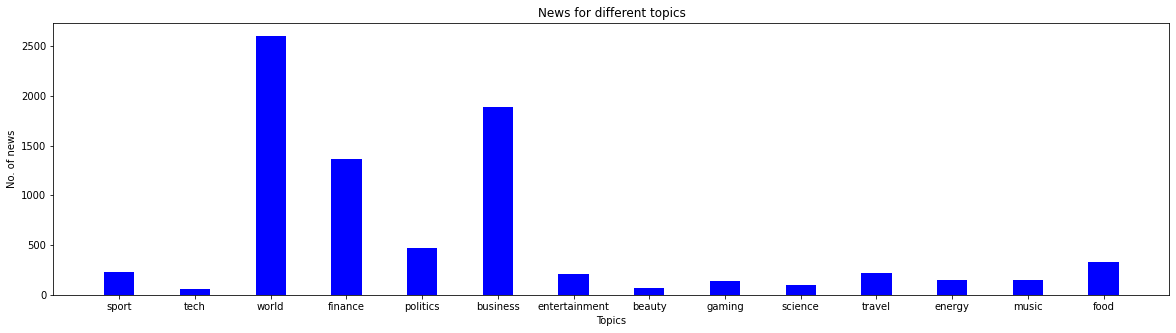

In [57]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(label_names, preds_count, color ='blue', width = 0.4)
 
plt.xlabel("Topics")
plt.ylabel("No. of news")
plt.title("News for different topics")
plt.show()

In [58]:
y = [r_news_topics[d] for d in y]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(vectorizedwords, y, test_size=0.3)

GaussianNBClassifier=GaussianNB()
GaussianNBClassifier.fit(X_train, y_train)
GaussianNBClassifier_acc = accuracy_score(y_test, GaussianNBClassifier.predict(X_test))
    
print(f"GaussianNB Classifier trained with accuracy: " + str(GaussianNBClassifier_acc))

GaussianNB Classifier trained with accuracy: 0.5240284162139573


In [60]:
multinomialNBClassifier=MultinomialNB()
multinomialNBClassifier.fit(X_train, y_train)
multinomialNBClassifier_acc = accuracy_score(y_test, multinomialNBClassifier.predict(X_test))
    
print(f"multinomialNB Classifier trained with accuracy: " + str(multinomialNBClassifier_acc))

multinomialNB Classifier trained with accuracy: 0.5445048056832428


In [27]:
test1_index = len(corpus)
corpus.append(remove_non_english_words("First Lunar Samples Brought to Earth Since 1976 Hints at Strange Volcanic Eruptions"))
test1 = cv.fit_transform(corpus).toarray()
y_val_1 = GaussianNBClassifier.predict([test1[test1_index]])
label_names[y_val_1[0]]

TypeError: ignored

In [135]:
y_val_1 = multinomialNBClassifier.predict([test1[test1_index]])
label_names[y_val_1[0]]

'gaming'

In [136]:
test2_index = len(corpus)
corpus.append(remove_non_english_words("The Chinese will extract oxygen from the soil of the moon The Chinese are not slowing down their space program, and as Chinese scientist Guo Linli revealed at a recent press conference, the lunar soil is rich in ilmenite and iron oxide, which they intend to use to extract oxygen from it. In his opinion, we are talking about up to 30 kilograms of oxygen obtained from every 100 kilograms of lunar soil, which could be necessary to maintain a permanent human presence on the moon. How do? We did not get exact information, but we know that it is about heating in a small reactor, where the temperature can reach 2500 degrees Celsius. Just as we have no idea if the relevant experiments were actually conducted by the Chang’e 5 spacecraft, which last year provided Chinese researchers with 2 kg of samples from previously unexplored regions of our satellite, but that’s to be expected. We know that according to scientists, the materials presented indicate that the Silver Globe has been volcanically active for much longer than we thought. According to Li Xianhua, their analyzes indicate about 2 billion years ago, and so far it was a period of 2.8 to 3 billion years ago. We would like to remind you that the Chinese brought the above samples to Earth in December of last year, that is, we are dealing with the first lunar material collected since the American and Soviet missions in the 1970s. Moreover, China is only the third country, after the United States and Russia, to send people into space on its own, but this certainly does not satisfy their ambitions, as evidenced by the Tiangong space station being built, a competitor to the International Space Station (ISS). In June of this year, the Middle Kingdom sent its first astronauts, and next year, others named Wentian and Mingtian will be connected to the Tianhe unit. All this to facilitate the conquest of the Moon and Mars, since the latter is also of interest to the Chinese Space Agency. For this purpose, the Tianwen-1 mission was created, the task of which is to explore the Red Planet in search of traces of life. This spring, we received proof that everything is going according to plan, because both the probe and the Zurong Mars rover are up and running and regularly upload new data and images to Earth (Curiosity has a few companies, after all). Back for a moment to the research station on the Moon, the construction and maintenance of which consists in the use of oxygen extracted from the “silver” soil. Its details are kept strictly confidential, which is somewhat understandable, but it also unfortunately raises concerns, especially since we learned in March of this year that the project was being dubbed International Lunar Research too skewed (or very skewed, as we’ll see.) In cooperation with the Russians. And although the Middle Kingdom asserts that it is a facility for “interdisciplinary and multi-subject research, including lunar exploration,” we have in the back of our mind reports of the latest Chinese military tests in space."))
test2 = cv.fit_transform(corpus).toarray()
y_val_2 = GaussianNBClassifier.predict([test2[test2_index]])
label_names[y_val_2[0]]

'economics'

In [137]:
y_val_2 = multinomialNBClassifier.predict([test2[test2_index]])
label_names[y_val_2[0]]

'world'

In [417]:
test3_index = len(corpus)
corpus.append(remove_non_english_words("Paul Walker's daughter Meadow is married! Paul Walker's daughter, Meadow, is married. The 22-year-old and actor Louis Thornton-Allan got engaged in August after making their relationship Instagram official in July. On Friday, the model shared a black and white video of their marriage ceremony, with the caption 'we're married.' Fast & the Furious star Vin Diesel - who is her godfather - walked her down the aisle at the beachside wedding."))
test3 = cv.fit_transform(corpus).toarray()
y_val_3 = GaussianNBClassifier.predict([test3[test3_index]])
label_names[y_val_3[0]]

'world'

In [418]:
y_val_3 = multinomialNBClassifier.predict([test3[test3_index]])
label_names[y_val_3[0]]

'food'

In [424]:
correct = []
different_preds = []
general_news = []
correct_preds = 0
for i in range(len(y)):
      #print(preds[i] +  " :  " + true_preds[i] + " === " + docs[i])
      if(y[i] == true_preds[i]):
        correct_preds = correct_preds + 1
        correct.append(i)
      elif(true_preds[i] == 'general news'):
        general_news.append(i)
      else:
        different_preds.append(i)
     # print("=========================================")

print('correct_preds : ' + str(correct_preds) + " out of " + str(len(docs) - len(general_news)))

correct_preds : 110 out of 1468


In [425]:
for i in different_preds:
  if(preds[i] != 'general news'):
    print(preds[i] +  " :  " + true_preds[i] + " === " + docs[i])

world :  economics === Amazon India AgenciesThe 2021 e-commerce battle is heating up.Amazon India doesn't want Indians to wait any longer to begin their festive shopping. The e-commerce giant has advanced the Great Indian Festival (GIF) to October 3 from October 4 with early access for Prime members. The move came a day after its rival Flipkart announced that The Big Billion Days (TBBD) sale will begin from October 3. 
While Flipkart's sale is an eight-day event, Amazon India's GIF will be a month-long affair. HDFC Bank Debit/Cred
finance :  economics === festivals of India Pictures: festivals of India Photos / Images The country's largest public sector bank, the State Bank of India (SBI) has announced that as part of its festive season scheme, it will be offering credit score linked home loans at 6.7%, irrespective of the loan amount. SBI has also waived processing fees on home loans. Click here to know how to avail SBI home loan.more23 Sep, 2021, 02.10 PM IST21 Sep, 2021, 10.25 AM IS

In [421]:
for i in correct:
  if(preds[i] != 'general news'):
    print(preds[i] +  " :  " + true_preds[i] + " === " + docs[i])

world :  world === India News Video caption: India building collapses hours after it was evacuatedIndia building collapses hours after it was evacuatedNo loss of life was reported from the incident.By Geeta PandeyBBC News, HathrasRajini VaidyanathanBBC South Asia Correspondent By Angie BrownBBC Scotland, Edinburgh and East reporterBy Vikas PandeyBBC News, DelhiBy Soutik BiswasIndia correspondent
world :  world === India building collapses hours after evacuation An eight-storey building collapsed in the north Indian state of Himachal Pradesh after heavy rains triggered a landslide.Officials said the building had been evacuated hours before it collapsed in Shimla city on Thursday.Building collapses are not uncommon in India, especially during the monsoon season. Poor construction standards and dilapidated buildings are often blamed.
world :  world === How Modi speaks the language of India's millennials © PTI Prime Minister Narendra Modi remains popular with young Indians India has one of

In [422]:
for i in general_news:
  print(preds[i] +  " :  " + docs[i])

Streaming output truncated to the last 5000 lines.

The squad announcement comes after the England and Wales Cricket Board issued a statement last Friday to signal the five-Test Vodafone Ashes series would begin as scheduled in Brisbane on December 8.
world :  How The Liberal "Psychos" Are Pounding The Con Media By Canadian standards it's practically a revolution. Tens of thousands of angry Liberal supporters going after our ugly Con media.They are accusing them of trying to steal the election with their naked bias, and of using the Tofino fake scandal to try to get Justin Trudeau to resign.The revolutionaries even have a Twitter hash tag #CdnMediaFailed that has been trending for days.And has so disturbed the media conglomerate, the bullies are complaining that they're being bullied. In the wake of the heinous and threatening messages sent to journalists from different media companies, we are joining forces with other Canadian press organizations to denounce hate, threats and online h

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




world :  Iraqis Vote in General Election, a Test for Democratic System Sunday, October 10, 2021 at 6:50 am | ד' חשון תשפ"בIraqi Prime Minister Mustafa Al-Kadhimi arrives at a polling station to cast his vote, as Iraqis go to the polls to vote in the parliamentary election, at the Green Zone in Baghdad, Iraq on Sunday. (Iraqi Prime Minister Media Office/Handout via REUTERS)
Iraqis were voting on Sunday in a general election that many said they would boycott, having lost faith in the democratic system brought in by the U.S.-led invasion of 2003.
The election is being held several months early under a new law designed to help independent candidates – a response to mass anti-government protests two years ago.
world :  Airtel Top Eight fixtures out: Bullets to play Mafco, Wanderers date Moyale The fixtures for MK78 million Airtel Top Eight Knockout Cup have been released by Football Association of Malawi.
With the longest Super League season almost complete, teams will battle for the MK 17

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [81]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(docs)

In [82]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [83]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [86]:
for i in range(true_k):
 print("Cluster %d:" % i),
 for ind in order_centroids[i, :10]:
  print(' %s' % terms[ind])

Cluster 0:
 shares
 quarter
 holdings
 llc
 recent
 company
 nyse
 stock
 000
 management
Cluster 1:
 india
 said
 2021
 10
 new
 october
 day
 year
 market
 people


In [88]:
print('Prediction')
X = vectorizer.transform(["Nothing is easy in cricket. Maybe when you watch it on TV, it looks easy. But it is not. You have to use your brain and time the ball."])
predicted = model.predict(X)
print(predicted)

Prediction
[1]
